Tutorial based on Marsland's book (2014) and Bishop (2006).
PRML book figures are availabe at https://www.microsoft.com/en-us/research/people/cmbishop/.

# Perceptron

In [1]:
import numpy as np

In [2]:
class Perceptron:
    def __init__(self, inputs, targets, eta, epochs, random_state=None):
        self.inputs = inputs
        self.targets = targets
        self.eta = eta
        self.epochs = epochs
        if random_state:
            np.random.seed(random_state)
        self.progress = []
        return
    
    @staticmethod
    def _forward(inputs, weights):
        signal = np.dot(inputs, weights)
        return np.where(signal > 0, 1, 0)
    
    def fit(self):
        """
        """
        # Ensure target data is 2D
        if self.targets.ndim == 1:
            self.targets = self.targets.reshape((-1, 1))
            
        # Initilize weights to small numbers
        weights = np.random.rand(self.inputs.shape[1] + 1, self.targets.shape[1]) * 0.1 - 0.05
        bias = -np.ones((self.inputs.shape[0], 1))
        inputs_with_bias = np.hstack((self.inputs, bias))
        # print("DEBUG:: Inputs with bias: {}".format(inputs_with_bias))
        # print("DEBUG:: Targets: {}".format(self.targets))
        
        for i in range(self.epochs):
            outputs = self._forward(inputs_with_bias, weights)
            # print("DEBUG:: Outputs: {}".format(outputs.reshape((1, -1))))
            weights -= self.eta * np.dot(inputs_with_bias.T, outputs - self.targets)
            self.progress.append(outputs)

In [3]:
or_network = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])

In [4]:
p = Perceptron(or_network[:, :2], or_network[:, 2], eta=0.25, epochs=10, random_state=0)

In [5]:
p.fit()

In [6]:
from sklearn.model_selection import train_test_split
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
np.random.seed(0)

In [7]:
from IPython.display import Image

In [8]:
Image(url="https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/ch02/images/02_03.png", width=640)

Perceptron can only implement linear decision boundaries
(e.g., XOR gate is not linearly separable, so Perceptron will not converge.),
whereas three- or higher-layer networks to be discussed below can implement nonlinear decision boundaries.

# Multilayer Perceptron (MLP)

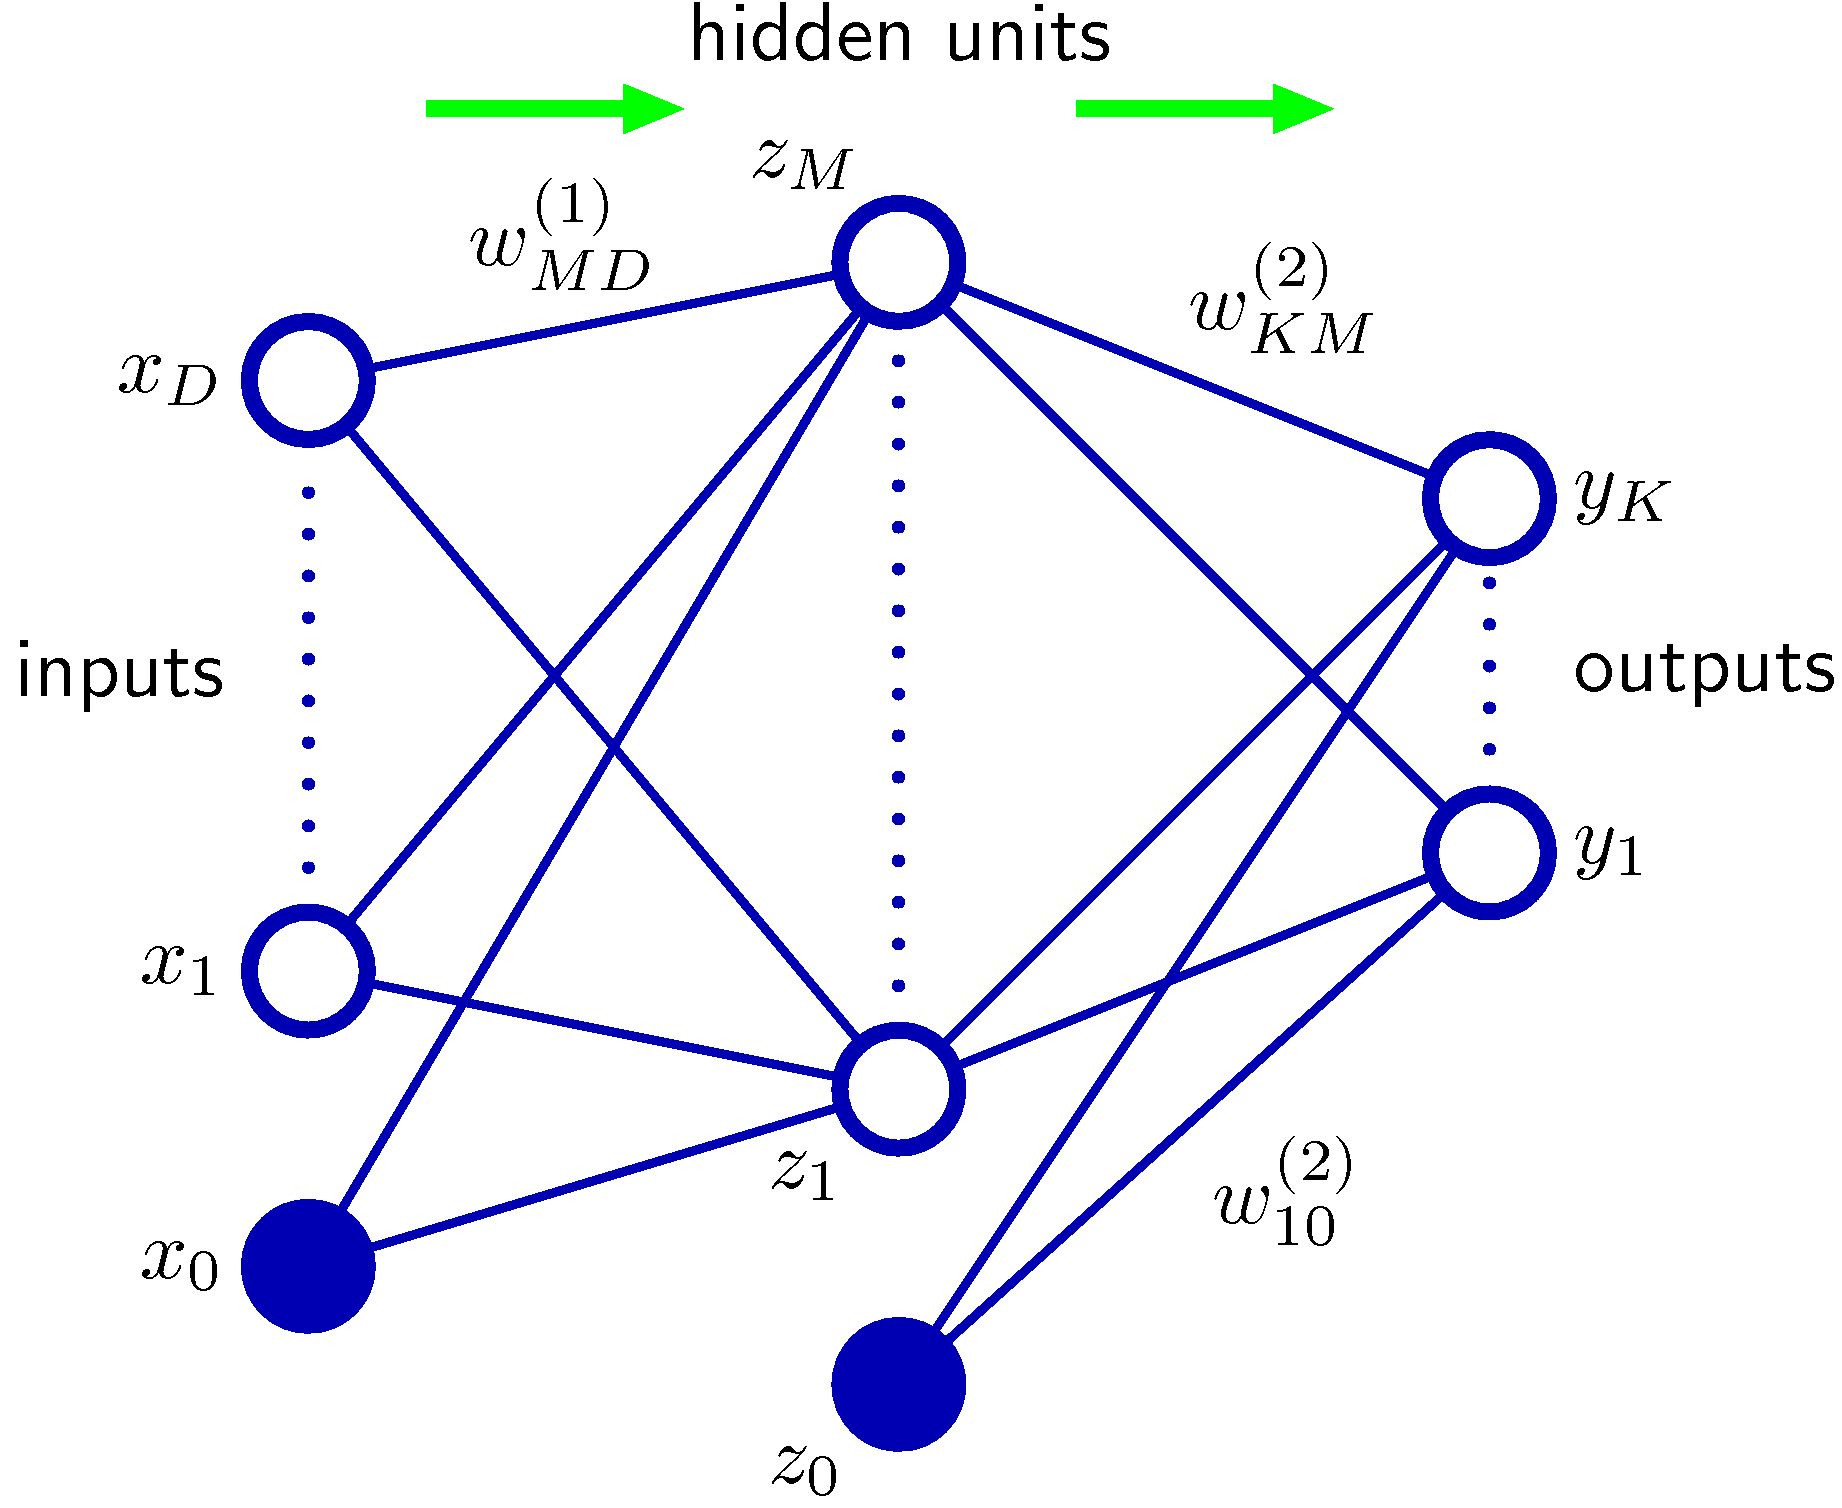

In [9]:
Image("../figures/PRML/Figure5.1.png", width=400)

## Feed-foward

Each hidden node has the weighted sum of its inputs nodes to form an activation given by

$$a_j = \sum_{i=0}^{D} w^{(1)}_{ji} x_i$$

where $x_0 = -1$ is the input bias node.
Then each of them is transformed using a differentiable, nonlinear activation function $h$ to give

$$z_j = h(a_j)$$

This function is generally chosen to be sigmoidal functions, and in the implementation we use `expit` from `scipy` module.
Similarly, each output unit computes its activation given by

$$a_k = \sum_{j=0}^{M} w^{(2)}_{kj} z_j$$

where $M$ is the number of hidden units, and $z_0$ is the hidden bias node whose output is always $z_0 = -1$.
Finally, each output unit activation is transformed using an activation function.
For example, for standard regression problems the identity is used ($y_k  = a_k$),
for multiple binary classification problems a sigmoid function ($y_k = \sigma(a_k)$),
and for multiclass problems a softmax function.

This successive calculation of the weighted sums is often called _forward propagation_.

### Weights

The weights are initialized to small random numbers, but how small is small?
If the weights are too small, the output of the neuron is linear, so we get a linear model.
If the weights are close to $-1$ or $1$, then the sigmoid will saturate giving us either $0$ or $1$.
We want the activation at the hidden layer in the range $(-1, 1)$.

Since we want both negative and positive weights, we can choose weights from a uniform distribution.
The activation from $D$ random variables of variance 1.0 will be $w \sqrt{D}$.
So the trick is to set the input-to-hidden weights in the range $-1/\sqrt{D} < w_{ji} < 1/\sqrt{D}$,
and hidden-to-output weights $-1/\sqrt{M} < w_{kj} < 1/\sqrt{M}$.

## Backpropagation

### Error Function

We are interested in minimizing the _sum-of-squares_ error function given by

$$E = \frac{1}{2} \sum_{k=1}^{K} (y_k - t_k)^2$$

The code implements the sum-of-squares error.
However, one can use as an alternative the _cross entropy_ error function:

$$E = -\sum_{k=1}^{K} t_k \ln y_k$$

###  Backpropagation and Error Function Derivatives

Now we evaluate the derivative of $E_n$ w.r.t. a weight $w_{kj}$.

$$\frac{\partial E_n}{\partial w_{kj}}
= \frac{\partial E_n}{\partial a_k} \frac{\partial a_k}{\partial w_{kj}}$$

Typically $\delta_k \equiv \partial E_n / \partial a_k$ is referred to as _errors_ or,
with a minus sign, _sensitivity_. Then

$$\frac{\partial E_n}{\partial w_{kj}} = \delta_k z_j$$

### Gradient Descent Algorithm

The backpropagation learning rule is based on gradient descent.
The weights that are initialized with random small values are changed in the direction
that reduces the error

$$\Delta w_{ji} = \eta \frac{\partial E}{\partial w_{ji}} = \eta \delta_j z_i$$

The updates for the hidden-to-output weights and the input-to-hidden weights, respectively,
have the form

$$w_{kj}^{(t+1)} \leftarrow w^{(t)} + \eta \delta_k z_j$$

$$w_{ji}^{(t+1)} \leftarrow w^{(t)} + \eta \delta_j x_i$$

where $\eta$ is the learning rate.

### Backpropagation (continued)

Now we need to work out $\delta_k$ and $\delta_j$.

$$\delta_k = 
\frac{\partial E}{\partial y_k} \frac{\partial y_k}{\partial a_k}
= (y_k - t_k) h'(a_k)$$

So we have $\delta_k = y_k - t_k$ for the linear output activation.
The learning rule for the input-to-hidden nodes require a bit more work. Using

$$\frac{\partial E}{\partial w_{ji}} = 
\frac{\partial E}{\partial z_j}
\frac{\partial z_j}{\partial a_j}
\frac{\partial a_j}{\partial w_{ji}}$$

The terms on the RHS can be derived (not included in the notebook) and combined to give

$$\delta_j = h'(a_j) \sum_{k=1}^{K} w_{kj} \delta_k$$

This is the _backpropagation_ formula which tells us that $\delta$ for each hidden unit
is obtained by propagating $\delta$'s backwards from units higher up in the network.

For each output activation function, we have to compute

$$\frac{\partial E}{\partial w_{kj}}
= \sum_{\ell = 1}^{K} \frac{\partial E}{\partial y_\ell}
  \frac{\partial y_\ell}{\partial a_k}
= h'(a_j) \sum_{\ell} w_{\ell j} \frac{\partial y_k}{\partial a_\ell}$$

We state the results here for each output activation.

$$\begin{align}
\mbox{Linear:    } & \frac{\partial y_k}{\partial a_j} = \delta_{kj} \\
\mbox{Sigmoid:    } & \frac{\partial y_k}{\partial a_j} = \delta_{kj} \sigma'(a_j) \\
\mbox{Softmax:    } & \frac{\partial y_k}{\partial a_j} = \delta_{kj} y_k - y_k y_j
\end{align}$$

Note that the derivative of a sigmoid function has a simple form
$\sigma'(a) = 1 - \sigma (a)^2$.


### Momentum Term

Adding a momenutm term can help the learning escape plateaus in the error function.
It also makes possible using a smaller learning rate (if the learning rate is too big, we overshoot the global minimum.)
We can alter the weight updates so that it includes some fraction $\alpha$ of the previosu weight update.

$$w^{(t+1)} \leftarrow w^{(t)} + \eta \delta_k z_j + \alpha \Delta w^{(t)}$$

## Early Stopping

If the learning rate is adequately chosen, the training errors tend to reduce monotonically,
and the reduction slows down as the amount of training (epochs) increases.
To prevent overfitting, we can first train the network for predetermined epochs,
and use the validation set to estimate how well the network is generalizing.
At some point, the validation error will start increasing, and this is the point we stop the training.

## Code

In [10]:
class MLP:
    def __init__(self, inputs, targets, n_hidden, beta=1, momentum=0.9,
                 activation="logistic", random_state=None, n_class=None):
        np.random.seed(random_state)
        self.inputs = inputs
        if targets.ndim == 1:
            targets = targets.reshape((-1, 1))
        if n_class:
            targets = self._onehot_encoder(targets, n_class)
        self.targets = targets
        self.n_samples, self.n_features = inputs.shape
        self.n_hidden = n_hidden
        self.n_output = targets.shape[1]
        self.w1, self.w2 = self._initialize_weights()
        self.beta = beta
        self.momentum = momentum
        self.activation = activation  # output activation function

    @staticmethod
    def _onehot_encoder(targets, k):
        """one-hot encoding of targets (labels)
        """
        onehot = np.zeros((targets.shape[0], k))
        for ti, t in enumerate(targets):
            onehot[ti, t] = 1
        return onehot
        
    def _initialize_weights(self):
        """Initialize weights with small random numbers
        """
        # w1 = (2 * np.random.rand(self.n_features + 1, self.n_hidden) - 1)  # add 1 for bias node
        # w1 = w1 / np.sqrt(self.n_features)
        # w2 = (2 * np.random.rand(self.n_hidden + 1, self.n_output) - 1)
        # w2 = w2 / np.sqrt(self.n_hidden)
        
        w1 = np.random.uniform(-1.0, 1.0, size=(self.n_features + 1) * self.n_hidden)\
             / np.sqrt(self.n_features)
        w1 = w1.reshape((self.n_features + 1, self.n_hidden))
        w2 = np.random.uniform(-1.0, 1.0, size=(self.n_hidden + 1) * self.n_output)\
             / np.sqrt(self.n_hidden)
        w2 = w2.reshape((self.n_hidden + 1, self.n_output))
        
        return w1, w2

    def _add_bias_node(self, inputs):
        return np.hstack((inputs, -np.ones((inputs.shape[0], 1))))

    def early_stopping(self, valid_inputs, valid_targets, eta, epochs=100):
        """
        """
        valid_inputs = self._add_bias_node(valid_inputs)
        if valid_targets.ndim == 1:
            valid_targets = valid_targets.reshape((-1, 1))

        best_valid_error = 100001
        valid_error = 100000

        cnt = 0
        while best_valid_error - valid_error > 1e-3:
            cnt += 1
            print("==> Validation iteration count: {}".format(cnt))
            self.fit(eta, epochs)
            # best_train_error = self.error_[-1]
            best_valid_error = valid_error
            valid_outputs = self._forward(valid_inputs, self.w1, self.w2)
            valid_error = ((valid_targets - valid_outputs) ** 2).sum() / 2.0
            print("....Validation error: {}".format(valid_error))

    def fit(self, eta, epochs):
        self.error_ = []
        delta_w1 = np.zeros(self.w1.shape)
        delta_w2 = np.zeros(self.w2.shape)

        inputs = self._add_bias_node(self.inputs)

        for i in range(epochs):
            outputs = self._forward(inputs, self.w1, self.w2)
            error = ((outputs - self.targets) ** 2).sum() / 2.0
            self.error_.append(error)

            if i % 100 == 0:
                print("....Iteration {:3d}: error = {}".format(i, error))

            # backpropagation
            if self.activation == "linear":
                output_deltas = (outputs - self.targets) / self.n_samples
            elif self.activation == "logistic":
                output_deltas = self.beta\
                    * (outputs - self.targets) * outputs * (1.0 - outputs)
            elif self.activation == "softmax":
                # TODO: 
                output_deltas = (outputs - self.targets) * outputs * (1.0 - outputs)\
                    / self.n_samples
            else:
                raise ValueError("ERROR:: activation function not recognized")
            
            hidden_deltas = self.hidden_outputs * self.beta * (1.0 - self.hidden_outputs)\
                * (np.dot(output_deltas, self.w2.T))

            delta_w1 = eta * (np.dot(inputs.T, hidden_deltas[:, :-1]))\
                + self.momentum * delta_w1
            delta_w2 = eta * (np.dot(self.hidden_outputs.T, output_deltas))\
                + self.momentum * delta_w2
            
            self.w1 -= delta_w1
            self.w2 -= delta_w2

    def _forward(self, inputs, w1, w2):
        """forward propagation
        """
        # inputs = self._add_bias_node(inputs)
        z = self.beta * np.dot(inputs, w1)
        z = self._sigmoid(z)
        self.hidden_outputs = self._add_bias_node(z)
        outputs = np.dot(self.hidden_outputs, w2)
        if self.activation == "linear":
            return outputs
        elif self.activation == "logistic":
            return self._sigmoid(self.beta * outputs)
        elif self.activation == "softmax":
            denom = np.sum(np.exp(outputs), axis=1).reshape((-1, 1))
            return np.exp(outputs) / denom
        else:
            raise ValueError("ERROR:: activation function not recognized")

    def predict(self, X):
        inputs = self._add_bias_node(X)
        outputs = self._forward(inputs, self.w1, self.w2)
        if self.targets.shape[1] == 1:
            y_pred = np.where(outputs > 0.5, 1, 0)
        else:
            y_pred = np.argmax(outputs, axis=1)
            
        return y_pred
    
    def _sigmoid(self, z):
        return expit(z)

## Training example 1

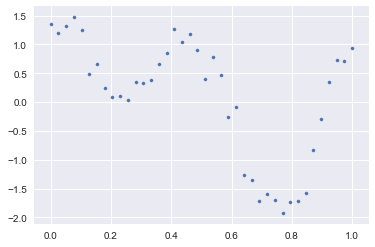

In [11]:
X = np.linspace(0, 1, 40).reshape((1, -1))
y = np.sin(2 * np.pi * X) + np.cos(4 * np.pi * X) + np.random.randn(40) * 0.2
plt.scatter(X, y, s=10)

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
# X_train = X_train.reshape((-1, 1))
# X_valid = X_valid.reshape((-1, 1))

In [13]:
X_train = X[0::2, :]
X_valid = X[3::4, :]
y_train = y[0::2, :]
y_valid = y[3::4, :]

In [14]:
nn = MLP(X_train, y_train, 3, activation="linear", random_state=0)
nn.fit(0.25, 200)

....Iteration   0: error = 21.1567808968
....Iteration 100: error = 1.48092445155e-05


## Example: The Iris Dataset

In [15]:
from sklearn import datasets

In [16]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [17]:
# incorporated this in MLP using _onehot_encoder
# y_encoded = np.zeros((y.shape[0], 3))
# y_encoded[np.where(y == 0), 0] = 1
# y_encoded[np.where(y == 1), 1] = 1
# y_encoded[np.where(y == 2), 2] = 1

In [18]:
X_train, y_train = X[::2], y[::2]
X_test, y_test = X[3::4], y[3::4]
X_valid, y_valid = X[1::4], y[1::4]

In [19]:
nn2 = MLP(X_train, y_train, 5, n_class=3, activation="softmax")

In [20]:
nn2.early_stopping(X_valid, y_valid, 0.1, 201)

==> Validation iteration count: 1
....Iteration   0: error = 25.3186863017
....Iteration 100: error = 11.8662696213
....Iteration 200: error = 6.13465350074
....Validation error: 69.3407682427
==> Validation iteration count: 2
....Iteration   0: error = 6.09203657001
....Iteration 100: error = 3.64028132545
....Iteration 200: error = 2.60857660071
....Validation error: 71.9002402785


In [21]:
from __future__ import division

def accuracy_score(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_pred)

In [22]:
y_pred = nn2.predict(X_test)
accuracy_score(y_test, y_pred)

0.94594594594594594

## Another example

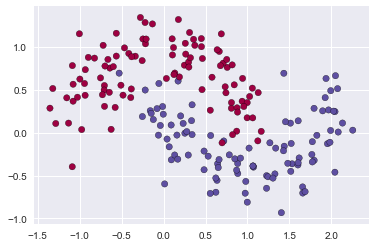

In [23]:
X, y = datasets.make_moons(200, noise=0.2, random_state=0)
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Spectral, s=40, c=y, edgecolor='k')

In [24]:
X_train, y_train = X[::2],  y[::2]
X_valid, y_valid = X[1::4], y[1::4]

In [25]:
nn3 = MLP(X_train, y_train, 3, activation="logistic", random_state=0)

In [26]:
nn3.fit(0.2, 400)

....Iteration   0: error = 12.3324676737
....Iteration 100: error = 2.52961980135
....Iteration 200: error = 1.2489214539
....Iteration 300: error = 0.606909430768


In [27]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

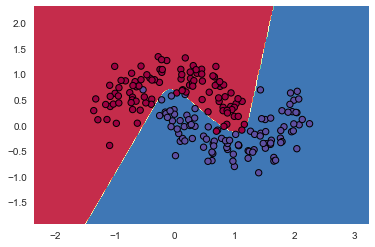

In [28]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

Z = nn3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=40, edgecolor='k', linewidth=1)